# Pong Agent!

**Required Libraries**

In [4]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

**Starting Pong Enviornment**

In [ ]:
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")

**Utility Functions + Tests**

Text(0.5, 1.0, 'After (Pre-Processed):  (80, 80)')

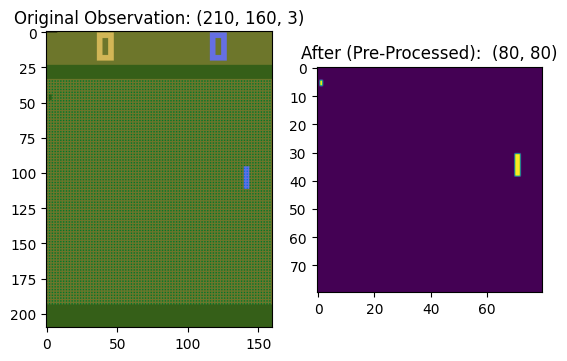

In [29]:
# Preprocessing Frames 
def frame_preprocessing(observation_frame):
    # Crop the frame.
    observation_frame = observation_frame[35:195]
    # Downsample the frame by a factor of 2.
    observation_frame = observation_frame[::2, ::2, 0]
    # Remove the background and apply other enhancements.
    observation_frame[observation_frame == 144] = 0  # Erase the background (type 1).
    observation_frame[observation_frame == 109] = 0  # Erase the background (type 2).
    observation_frame[observation_frame != 0] = 1  # Set the items (rackets, ball) to 1.
    # Return the preprocessed frame as a 1D floating-point array.
    return np.array(observation_frame.astype(float))

env.seed(42)
env.reset()
observation, info = env.reset(seed=42)
processed_observation = frame_preprocessing(observation)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(observation)
plt.title(f"Original Observation: {observation.shape}")
plt.subplot(1,2,2)
plt.imshow(processed_observation)
plt.title(f"After (Pre-Processed):  {processed_observation.shape}")

testing function:

In [9]:
frame.shape

AttributeError: 'tuple' object has no attribute 'shape'

Pong

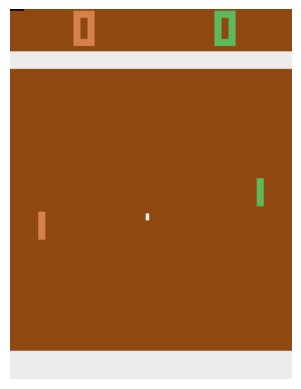

In [36]:
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")

# Reset the environment to start
state = env.reset()

# Example: Perform 10 steps in the environment with random actions
for _ in range(15):
    action = env.action_space.sample() 
    state, reward, done, info, frame = env.step(0)
    # plt.figure()
    # plt.imshow(state)
    # plt.axis('off')
    if done:
        break  # If the game is over, exit the loop

# Display the current frame

plt.axis('off')  # Hide axes
plt.imshow(state)